Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Balanced Model: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}


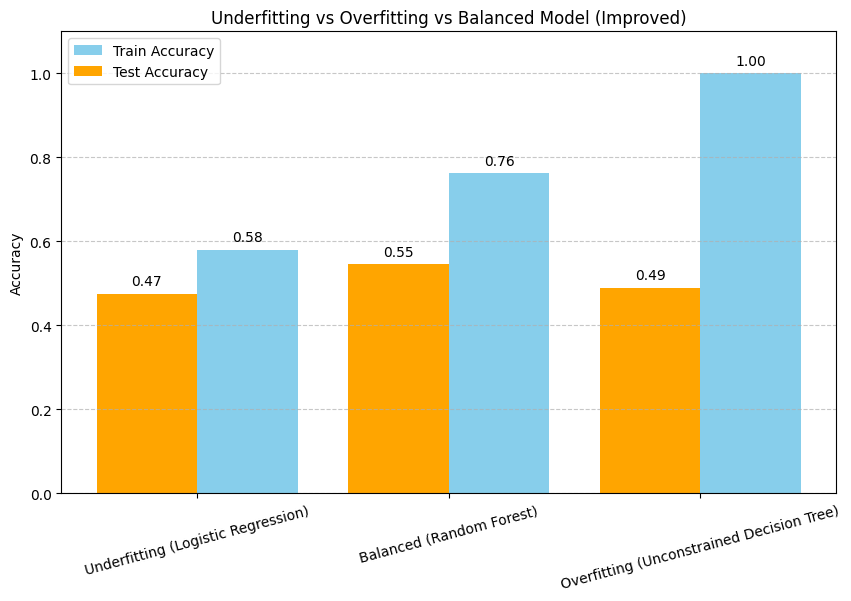

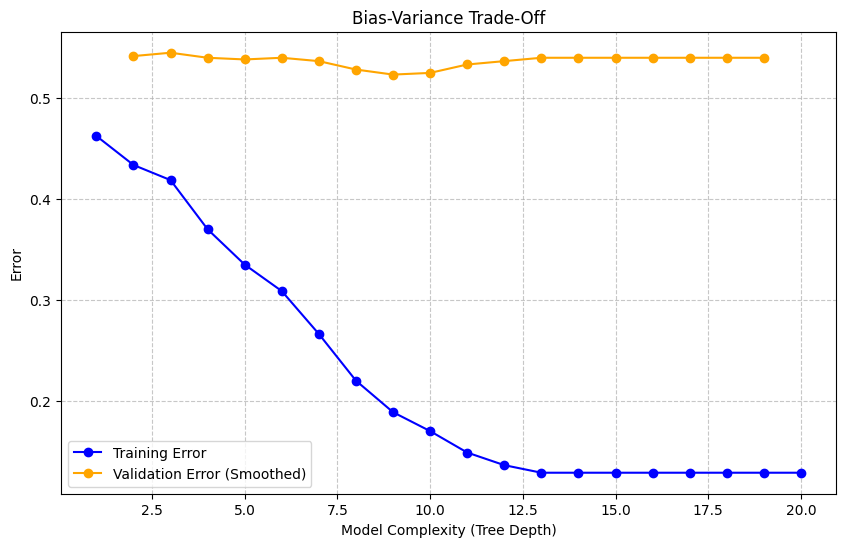

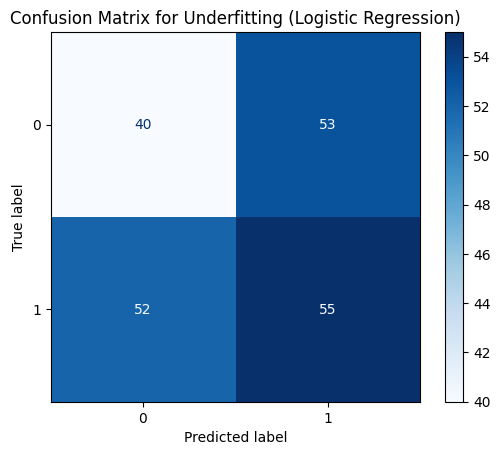

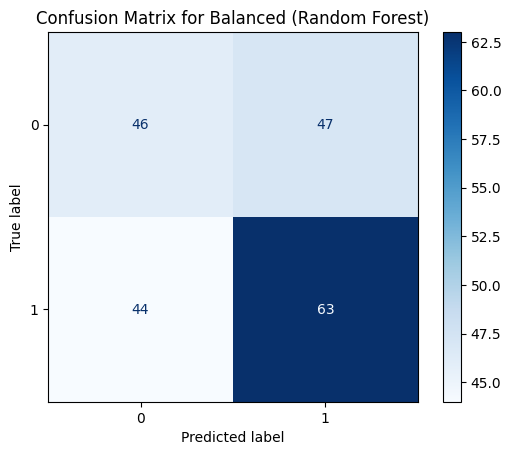

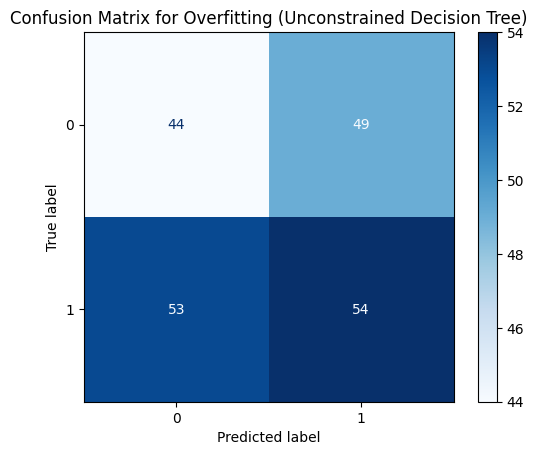

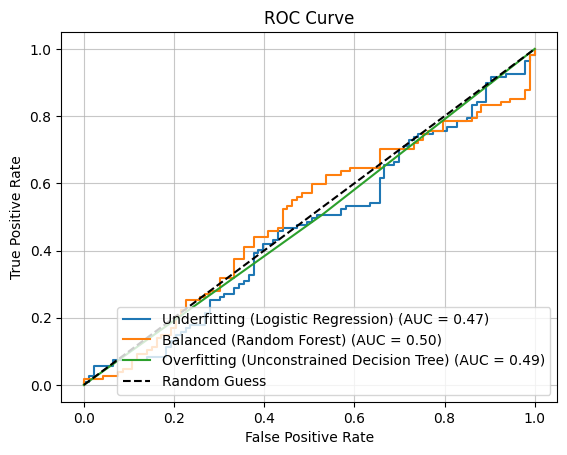

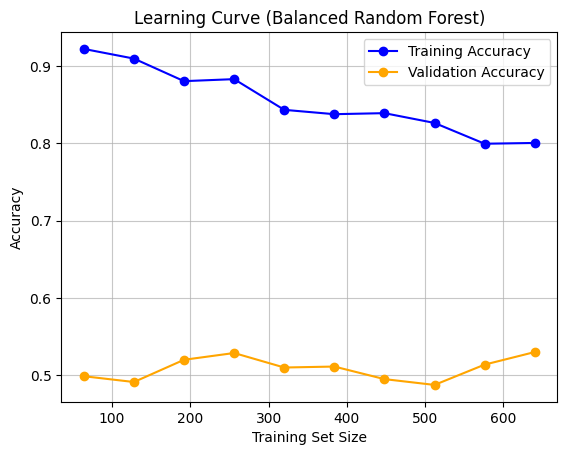

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the dataset
classification_data = pd.read_csv('/content/data set.csv')

# Preprocessing
classification_data = classification_data.dropna(axis=1, how='all')  # Drop empty columns
X = classification_data.iloc[:, :-1]  # All columns except the last one as features
y = classification_data.iloc[:, -1]  # Last column as target

# Encode non-numeric target and features
le = LabelEncoder()
if y.dtype == 'object':
    y = le.fit_transform(y)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = le.fit_transform(X[col].astype(str))

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Feature Selection: Select top 10 features based on ANOVA F-statistic
k_best = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = k_best.fit_transform(X_resampled, y_resampled)
X_test_kbest = k_best.transform(X_test)

# Models
underfit_model = LogisticRegression(max_iter=500, penalty='l2', C=0.01, random_state=42)  # Underfitting model
balanced_model = RandomForestClassifier(random_state=42)  # To be tuned
overfit_model = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)  # Overfitting model

# Hyperparameter tuning for balanced model
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=balanced_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Perform RandomizedSearchCV
random_search.fit(X_train_kbest, y_resampled)
balanced_model = random_search.best_estimator_  # Best model after tuning
print("Best Parameters for Balanced Model:", random_search.best_params_)

# Train and evaluate all models
models = {
    "Underfitting (Logistic Regression)": underfit_model,
    "Balanced (Random Forest)": balanced_model,
    "Overfitting (Unconstrained Decision Tree)": overfit_model
}

train_accuracies, test_accuracies = [], []
for name, model in models.items():
    model.fit(X_train_kbest, y_resampled)
    train_accuracies.append(accuracy_score(y_resampled, model.predict(X_train_kbest)))
    test_accuracies.append(accuracy_score(y_test, model.predict(X_test_kbest)))

# Visualize train vs test accuracy
plt.figure(figsize=(10, 6))
bars_train = plt.bar([x + 0.2 for x in range(len(models))], train_accuracies, width=0.4, label="Train Accuracy", color='skyblue')
bars_test = plt.bar([x - 0.2 for x in range(len(models))], test_accuracies, width=0.4, label="Test Accuracy", color='orange')

# Annotate bars
for i, acc in enumerate(train_accuracies):
    plt.text(i + 0.2, acc + 0.02, f'{acc:.2f}', ha='center')
for i, acc in enumerate(test_accuracies):
    plt.text(i - 0.2, acc + 0.02, f'{acc:.2f}', ha='center')

plt.xticks(range(len(models)), models.keys(), rotation=15)
plt.ylabel("Accuracy")
plt.title("Underfitting vs Overfitting vs Balanced Model (Improved)")
plt.legend()
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bias-Variance Trade-Off (Decision Tree Depth vs Error)
depths = range(1, 21)
train_errors, test_errors = [], []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=10, random_state=42)
    model.fit(X_train_kbest, y_resampled)
    train_errors.append(1 - accuracy_score(y_resampled, model.predict(X_train_kbest)))
    test_errors.append(1 - accuracy_score(y_test, model.predict(X_test_kbest)))

# Smooth the validation curve using a rolling average
test_errors_smooth = pd.Series(test_errors).rolling(window=3, center=True).mean()

plt.figure(figsize=(10, 6))
plt.plot(depths, train_errors, label="Training Error", marker="o", color='blue')
plt.plot(depths, test_errors_smooth, label="Validation Error (Smoothed)", marker="o", color='orange')
plt.title("Bias-Variance Trade-Off")
plt.xlabel("Model Complexity (Tree Depth)")
plt.ylabel("Error")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test_kbest, y_test, cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Ensure the model can produce probabilities
        y_prob = model.predict_proba(X_test_kbest)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.7)
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    balanced_model, X_train_kbest, y_resampled, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o', color='blue')
plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker='o', color='orange')
plt.title("Learning Curve (Balanced Random Forest)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.7)
plt.show()
